In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
import cv2
import os

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1,0]]
            frames.append(frame)
            
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [ ]:
# Feature Extraction
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
    weights = 'imagenet',
    include_top = False,
    pooling = 'avg',
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input
    
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)
    
    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name='feature_extractor')

feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

# print(f'Total videos for training: {len(train_df)}')
# print(f'Total videos for testing: {len(test_df)}')
label_processor = keras.layers.StringLookup(num_oov_indices=1, vocabulary=np.unique(train_df['tag']))
print(label_processor.get_vocabulary())

# labels = train_df['tag'].values
# labels = label_processor(labels[..., None]).numpy()
# labels

['[UNK]', 'Barking', 'Digging', 'Dropped Jaw & Tongue', 'Hyper Salivation', 'Incoordination', 'Paralysis', 'Playing', 'Running', 'Seizure', 'Wagging Tail']


In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

In [27]:
# the code with count of frames set to 10
from google.colab.patches import cv2_imshow


def Video_play(video_path):   
    cap = cv2.VideoCapture(video_path) 
    if (cap.isOpened() == False): 
        print("Error opening video stream or file.")
    count = 0
    display_count = 0
    while (cap.isOpened()):
        ret, frame = cap.read()
        count += 1
        if ret == True:
            face_detector = cv2.CascadeClassifier('cascade.xml')
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

            for (x, y, w, h) in num_faces:
                if Rab > Nor:
                    cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 0, 255), 4)
                    cv2.putText(frame, f"Rabies", (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2, 
                                cv2.LINE_4)
                elif Nor > Rab:
                    cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
                    cv2.putText(frame, f"Normal", (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2,
                                cv2.LINE_4)
                else:
                    cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 4)

            # Display every 10th frame
            if count <=3:
                cv2_imshow(frame)
                display_count += 1
            if display_count==3:
                break
            # if cv2.waitKey(1) & 0xFF == ord('q'):
            #     break
        else:
            break

    cap.release()
    cv2.destroyAllWindows()
    print(f"Total frames processed: {count}")
    print(f"Total frames displayed: {display_count}")



Button(description='Upload Video', style=ButtonStyle())

Saving 002.mp4 to 002.mp4
1/1 [==============================] - 4s 4s/step
Details:
  Paralysis: 70.62%
  Seizure: 15.79%
  Playing:  5.89%
  Hyper Salivation:  3.00%
  Digging:  2.58%
Since features of rabies are more dominating among the features shown, the final result can be assumed as RABIES.


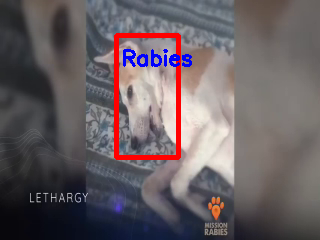

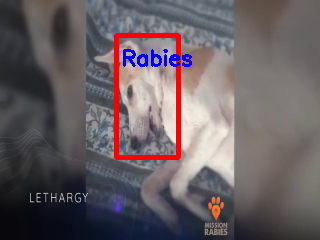

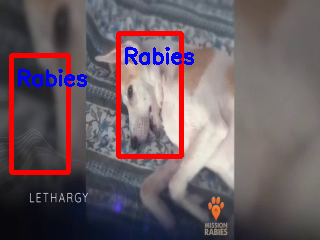

Total frames processed: 3
Total frames displayed: 3


In [28]:

from IPython.display import display
import ipywidgets as widgets
from google.colab import files
from IPython.display import HTML
import base64
import tensorflow as tf
import numpy as np

Rabies = ['Paralysis', 'Dropped Jaw & Tongue', 'Hyper Salivation', 'Incoordination', 'Seizure']
Normal = ['Barking', 'Running', 'Playing', 'Wagging Tail', 'Digging']
Rab = 0
Nor = 0
No_Detect = 0

# Load the model from the saved files
with open('model.json', 'r') as f:
    model_json = f.read()
sequence_model = tf.keras.models.model_from_json(model_json)
sequence_model.load_weights('model.h5')

def sequence_prediction(path):
    global Rab
    global Nor
    global No_Detect
    count = 0
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(path)  # You need to define or import this function
    frame_features, frame_mask = prepare_single_video(frames)  # You need to define or import this function
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    print('Details:')
    for i in np.argsort(probabilities)[::-1]:
        if count < len(Rabies):
            if class_vocab[i] == 'No Detection':
                No_Detect += 1
            print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
            if class_vocab[i] in Rabies:
                Rab += 1
            else:
                Nor += 1
        count += 1
    return frames

def upload_video(_):
    global Rab
    global Nor
    global No_Detect
    Rab = 0
    Nor = 0
    No_Detect = 0
    uploaded = files.upload()
    for name, data in uploaded.items():
        test_frames = sequence_prediction(name)
        if Rab > Nor:
            print(f'Since features of rabies are more dominating among the features shown, the final result can be assumed as RABIES.')
        elif Nor > Rab:
            print(f'Since features of normal are more dominating among the features shown, the final result can be assumed as NORMAL.')
        else:
            print('No dog detected.')
    Video_play(name)

upload_button = widgets.Button(description="Upload Video")
upload_button.on_click(upload_video)
display(upload_button)

